In [3]:
from google.colab import files
files.upload()

Saving creditcard.csv.zip to creditcard.csv.zip


In [4]:
!unzip creditcard.csv.zip

Archive:  creditcard.csv.zip
  inflating: creditcard.csv          


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv('creditcard.csv')

In [7]:
df.shape

(284807, 31)

In [8]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [9]:
df.Time.describe()

count    284807.000000
mean      94813.859575
std       47488.145955
min           0.000000
25%       54201.500000
50%       84692.000000
75%      139320.500000
max      172792.000000
Name: Time, dtype: float64

Text(0, 0.5, 'count')

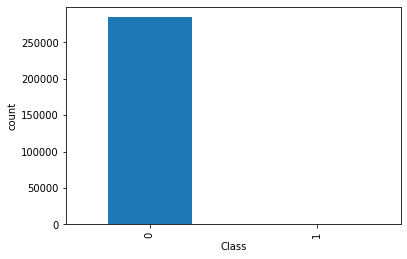

In [10]:
# target

df['Class'].value_counts().plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('count')

엄청난 불균형!

1. 데이터를 더 모은다..

2. 평가 지표?

3. resampling (oversampling/undersampling)

In [11]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


V1~V28 (뭔진 모르겠지만) 의 분포와 amount의 분포가 다르기 때문에, 
logistic regression 모델에 넣어주려면 scaling을 해야한다.

In [12]:
from sklearn.preprocessing import StandardScaler

In [13]:
df['normAmount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
df = df.drop(['Time', 'Amount'], axis=1)
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


In [14]:
# Resampling ; undersampling으로 50:50 비율 만듦

fraud_num = len(df[df.Class == 1]) # 사기 개수만큼
fraud_idx = np.array(df[df.Class == 1].index)

normal_idx = df[df.Class==0].index

random_normal_idx = np.random.choice(normal_idx, fraud_num, replace=False) # 정상에서 랜덤 추출
random_normal_idx = np.array(random_normal_idx)

undersampled_idx = np.concatenate([fraud_idx, random_normal_idx])
undersampled_data = df.loc[undersampled_idx, :]

X = undersampled_data.drop('Class', axis=1)
y = undersampled_data.Class

y.value_counts()

1    492
0    492
Name: Class, dtype: int64

In [15]:
# making datasets

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print(f'train size : {len(X_train)}')
print(f'test size : {len(X_test)}')

train size : 688
test size : 296


Use Logistic Regression classifier

1. Undersampled data

2. skewed data (원본)

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report

In [21]:
KFold?

In [94]:
# KFold score 보여주는 함수

def print_KFold_score(X_tr, y_tr):
  
  fold = KFold(5, shuffle=False)
  C_param = [0.01, 0.1, 1, 10, 100]

  result_table = pd.DataFrame(index=range(len(C_param)), columns=['C', 'Mean recall score'])
  result_table['C'] = C_param

  j=0
  for C in C_param :
    print(f'C : {C}\n')

    recall_accs = []
    for iteration, idx in enumerate(fold.split(y_tr), start=1): # index 들의 배열을 리턴
        LR = LogisticRegression(C=C, penalty='l2', max_iter=1000)
        LR.fit(X_tr.iloc[idx[0]].values, y_tr.iloc[idx[0]].values.ravel())
        y_predict = LR.predict(X_tr.iloc[idx[1]].values)

        recall_acc = recall_score(y_tr.iloc[idx[1]].values, y_predict)
        recall_accs.append(recall_acc)
        print(f"Iteration : {iteration} : Recall score = {recall_acc} ")

    result_table.loc[j, 'Mean recall score'] = np.mean(recall_accs)
    j += 1
    print("Mean recall score :", np.mean(recall_accs))

    best_c = result_table.loc[result_table['Mean recall score'].idxmax()]['C']
    print("Best C :", best_c)

    return best_c


In [95]:
best_c = print_KFold_score(X_train, y_train)

C : 0.01

Iteration : 1 : Recall score = 0.821917808219178 
Iteration : 2 : Recall score = 0.863013698630137 
Iteration : 3 : Recall score = 0.9152542372881356 
Iteration : 4 : Recall score = 0.9324324324324325 
Iteration : 5 : Recall score = 0.8939393939393939 
Mean recall score : 0.8853115141018554
C : 0.1

Iteration : 1 : Recall score = 0.8493150684931506 
Iteration : 2 : Recall score = 0.9041095890410958 
Iteration : 3 : Recall score = 0.9661016949152542 
Iteration : 4 : Recall score = 0.9459459459459459 
Iteration : 5 : Recall score = 0.8939393939393939 
Mean recall score : 0.9118823384669682
C : 1

Iteration : 1 : Recall score = 0.863013698630137 
Iteration : 2 : Recall score = 0.9041095890410958 
Iteration : 3 : Recall score = 0.9830508474576272 
Iteration : 4 : Recall score = 0.9459459459459459 
Iteration : 5 : Recall score = 0.9090909090909091 
Mean recall score : 0.921042198033143
C : 10

Iteration : 1 : Recall score = 0.863013698630137 
Iteration : 2 : Recall score = 0.89041

In [54]:
# Plot confusion matrix

import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=0)
  plt.yticks(tick_marks, classes)

  if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  else:
        1

  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
      

In [61]:
# Plot confusion matrix on undersampled data

best_c = 0.01
lr = LogisticRegression(C=best_c, penalty='l2')
lr.fit(X_train, y_train.values.ravel())
y_pred = lr.predict(X_test.values)

cm = confusion_matrix(y_test, y_pred)
print(f"Recall metric : {cm[1,1] / (cm[1,0]+cm[1,1])}")

Recall metric : 0.8707482993197279


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


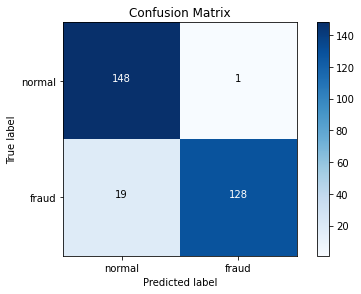

In [63]:
class_names = ['normal', 'fraud']
plt.figure()
plot_confusion_matrix(cm, classes=class_names, title='Confusion Matrix')
plt.show()

In [70]:
# Test on the whole data

y_true = df.Class
df.drop(['Class'], axis=1, inplace=True)
lr = LogisticRegression(C = best_c, penalty='l2')
lr.fit(X_train, y_train)
y_predict = lr.predict(df)

cm = confusion_matrix(y_true, y_predict)
print(f"Recall metric : {cm[1,1] / (cm[1,0]+cm[1,1])}")

Recall metric : 0.8841463414634146


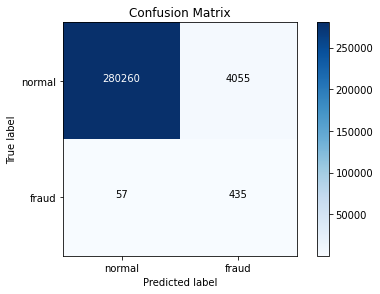

In [71]:
class_names = ['normal', 'fraud']
plt.figure()
plot_confusion_matrix(cm, classes=class_names, title='Confusion Matrix')
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


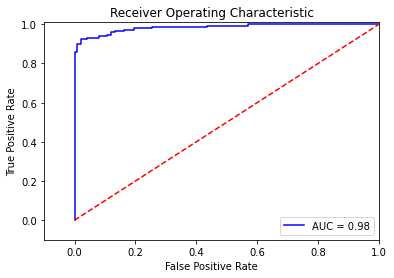

In [73]:
# ROC curve

lr = LogisticRegression(C=best_c, penalty='l2')
y_prediction_score = lr.fit(X_train, y_train.ravel()).decision_function(X_test.values)
fpr, tpr, thresholds = roc_curve(y_test.values.ravel(), y_prediction_score)
roc_auc = auc(fpr, tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()